In [1]:
import json, os, torch, sys
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pycocotools.mask as mask_util
from multiprocessing import Pool
# for unrec blend
from astropy.coordinates import search_around_sky, SkyCoord
from astropy.visualization import make_lupton_rgb
import astropy.units as u
from astropy.wcs import WCS
import pycocotools.mask as mask_util
# detectron2 and deepdisc
from detectron2.config import LazyConfig, instantiate
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import Instances, Boxes
from deepdisc.astrodet.visualizer import Visualizer, ColorMode
from deepdisc.data_format.register_data import register_data_set
from deepdisc.utils.norms import asinh_norm
from custom.mappers import FileNameWCSMapper

In [2]:
root_dir = os.path.expanduser('~/lsst_data/')
root_run_dir = os.path.expanduser('~/lsst_runs/')
folder = 'annotations_lvl5'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_data = pd.read_json(test_data_fn)
run_name = 'lsst5_30k_4h200_bs192_ep50'
# run_name = 'moco5_30k_4h200_bs256_ep50_unfrz'
run_dir = f'{root_run_dir}{run_name}/'
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")
print(f"Run name: {run_name} and run dir: {run_dir}")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 images.
Run name: lsst5_30k_4h200_bs192_ep50 and run dir: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/


In [28]:
cfg_file = os.path.expanduser("~/deepdisc/configs/solo/swin_lsst_job.py")
cfg = LazyConfig.load(cfg_file) # using a Swin Transformer
for key in cfg.get("MISC", dict()).keys():
    cfg[key] = cfg.MISC[key]

cfg.DATASETS.TEST = "test"
cfg.dataloader.augs = None # no augs for test set since we want preds on OG images
cfg.dataloader.test.mapper = FileNameWCSMapper # setting test DataLoader's mapper so that filename gets added to each sample
print(f"Config loaded successfully!")
print(f"Registering training dataset from: {test_data_fn}")
try:
    DatasetCatalog.remove(cfg.DATASETS.TEST)
    MetadataCatalog.remove(cfg.DATASETS.TEST)
except:
    pass
custom_colors = [
    (0, 255, 0),    # green for galaxies
    (0, 0, 255),    # blue for stars
]
astrotest_metadata = register_data_set(
    cfg.DATASETS.TEST, test_data_fn, thing_classes=cfg.metadata.classes, thing_colors=custom_colors
)
test_score_thresh = 0.25
nms_thresh = 0.6
print(f"Dataset registered successfully!")
print(f"Test Score Threshold: {test_score_thresh}")
print(f"NMS Threshold: {nms_thresh}")

Config loaded successfully!
Registering training dataset from: /u/yse2/lsst_data/annotations_lvl5/test_8k.json
Dataset registered successfully!
Test Score Threshold: 0.25
NMS Threshold: 0.6


In [29]:
pred_fn = f'{run_dir}preds/pred_s{test_score_thresh}_n{nms_thresh}.json'
print(f"Loading predictions from {pred_fn}")
with open(pred_fn, 'r') as f:
    dd_det = json.load(f)
dd_det_cat = pd.DataFrame(dd_det)

Loading predictions from /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/preds/pred_s0.25_n0.6.json


# Adding Magnitudes to DeepDISC Detections

In [30]:
dd_det_cat['file_name'].isna().sum()

np.int64(0)

In [31]:
def process_file_group(args):
    """
    Process all detections for a single cutout
    Args:
        args: Tuple of (file_name, list of detection dicts)
    Returns:
        List of dictionaries with id and calculated mags
    """
    fn, dets = args
    try:
        lsst_img = np.load(fn)
    except Exception:
        raise RuntimeError(f"Failed to load file: {fn}")
        # If file load fails, return NaN for all dets
        # return [{
        #     'id': det['id'],
        #     **{f'mag_{band}': np.nan for band in ['u', 'g', 'r', 'i', 'z', 'y']}
        # } for det in dets]
    bands = ['u', 'g', 'r', 'i', 'z', 'y']
    results = []
    for det in dets:
        try:
            # Reconstruct mask from RLE
            rle_dict = det['rle_masks'].copy()
            # 'counts' field was saved as a string for JSON format, so we encode it back to bytes
            rle_dict['counts'] = rle_dict['counts'].encode('utf-8')
            # decode RLE to a binary mask
            mask = mask_util.decode(rle_dict).astype(bool)
            mags = {'id': det['id']}
            for band_idx, band_name in enumerate(bands):
                band_image = lsst_img[band_idx]
                instrumental_flux = np.sum(band_image[mask])
                # edge case where flux might be zero or negative
                if instrumental_flux <= 0:
                    mags[f'mag_{band_name}'] = np.nan
                else:
                    mag = 27 - 2.5 * np.log10(instrumental_flux)
                    mags[f'mag_{band_name}'] = mag
            
            results.append(mags)
        except Exception:
            # NaN vals if processing fails
            results.append({
                'id': det['id'],
                **{f'mag_{band}': np.nan for band in bands}
            })
    return results
    
def calc_mags(dd_det_cat, n_processes=32):
    """
    Calculate mags for all detections using parallel processing
    Args:
        dd_det_cat: DataFrame with detection data
        n_processes: Number of parallel processes (default: 32)
    Returns:
        DataFrame with id and calculated magnitudes for all bands
    """
    # let's first group detections by file to avoid repeated loading
    grouped = dd_det_cat.groupby('file_name')
    # list of (file_name, list_of_dicts) tuples
    file_groups = [
        (file_name, group.to_dict('records')) 
        for file_name, group in grouped
    ]
    print(f"Processing {len(dd_det_cat)} detections from {len(file_groups)} files with {n_processes} CPUs")    
    # process file groups in parallel
    with Pool(processes=n_processes) as pool:
        results = pool.map(process_file_group, file_groups)
    # flatten list of lists into single list
    flat_res = [item for sublist in results for item in sublist]
    # results back to df
    mags_df = pd.DataFrame(flat_res)
    return mags_df

In [32]:
mags_df = calc_mags(dd_det_cat, n_processes=len(os.sched_getaffinity(0))) # 23.2s w/ 32 CPUs

Processing 300985 detections from 8571 files with 32 CPUs


In [33]:
# how many NaNs in each band?
mags_df.isna().sum()

id           0
mag_u    33248
mag_g     1549
mag_r       71
mag_i      661
mag_z    12691
mag_y    22268
dtype: int64

In [34]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
for band in bands:
    col_name = f'mag_{band}'
    total_mags = len(mags_df)
    valid_mags = mags_df[col_name].dropna()
    print(f"\n{band.upper()}-band:")
    print(f"  Valid mags: {len(valid_mags)}/{total_mags} ({len(valid_mags)/total_mags*100:.3f}%) ")
    if len(valid_mags) > 0:
        print(f"  Mean mag: {valid_mags.mean():.2f}")
        print(f"  Median mag: {valid_mags.median():.2f}")
        print(f"  Min mag: {valid_mags.min():.2f}")
        print(f"  Max mag: {valid_mags.max():.2f}")
    else:
        print(f"  No valid mags found")


U-band:
  Valid mags: 267737/300985 (88.954%) 
  Mean mag: 26.80
  Median mag: 26.88
  Min mag: 13.76
  Max mag: 39.80

G-band:
  Valid mags: 299436/300985 (99.485%) 
  Mean mag: 26.56
  Median mag: 26.73
  Min mag: 14.34
  Max mag: 37.76

R-band:
  Valid mags: 300914/300985 (99.976%) 
  Mean mag: 26.05
  Median mag: 26.30
  Min mag: 14.19
  Max mag: 34.21

I-band:
  Valid mags: 300324/300985 (99.780%) 
  Mean mag: 25.66
  Median mag: 25.90
  Min mag: 14.04
  Max mag: 36.20

Z-band:
  Valid mags: 288294/300985 (95.784%) 
  Mean mag: 25.36
  Median mag: 25.55
  Min mag: 14.01
  Max mag: 37.62

Y-band:
  Valid mags: 278717/300985 (92.602%) 
  Mean mag: 25.13
  Median mag: 25.32
  Min mag: 13.29
  Max mag: 37.93


In [35]:
dd_det_cat = dd_det_cat.merge(mags_df, on='id', how='left')
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.89894485473633, 17.910354614257812, 65.676...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O...",24.178501,24.361794,24.417967,24.268442,24.298439,23.601818
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.839725494384766, 122.48644256591797, 64.39...",0.996113,"{'size': [150, 147], 'counts': 'hk64`45L2N101N...",24.193335,24.437212,24.034464,23.551100,23.028345,22.912689
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.99774169921875, 41.76079559326172, 77.0943...",0.994500,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10...",26.306913,26.051395,25.227131,24.238522,23.961708,23.851330
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.68438720703125, 133.7821044921875, 115.389...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O...",26.619596,25.951719,25.406775,24.823856,24.747644,25.740545
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0696029663086, 100.67476654052734, 104.236...",0.988886,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N...",24.696024,24.835098,24.742519,24.630798,24.255783,23.613699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300980,300980,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.32826232910156, 135.40374755859375, 146.8...",0.527945,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}",NaN,28.596455,27.880468,27.188671,27.090696,26.914551
300981,300981,51.394556,-39.278706,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[11.441096305847168, 51.49355697631836, 22.464...",0.456089,"{'size': [144, 147], 'counts': 'hY23]4000Xna0'}",NaN,28.679873,28.023996,28.183262,28.777231,27.536844
300982,300982,51.386813,-39.279414,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[119.1473388671875, 38.506141662597656, 130.52...",0.400682,"{'size': [144, 147], 'counts': 'kZa02]42O01Oeh2'}",27.515423,28.312260,27.774233,27.715658,NaN,NaN
300983,300983,51.387233,-39.274176,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[112.56040954589844, 133.14857482910156, 125.4...",0.373702,"{'size': [144, 147], 'counts': 'Xg`04\41O00OY\3'}",26.667084,27.440823,27.372332,27.711397,27.127350,26.256882


In [36]:
dd_det_cat.to_json(f'{run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json', orient='records')
print(f"Saved predictions with magnitudes to {run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json")

Saved predictions with magnitudes to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/preds/pred_with_mag_s0.25_n0.6.json


In [37]:
dd_det_cat = pd.read_json(f'{run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json', orient='records')
print(f"Loaded predictions with magnitudes from {run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json")

Loaded predictions with magnitudes from /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/preds/pred_with_mag_s0.25_n0.6.json


# DeepDISC Magnitude Distributions

In [38]:
buffers = [1, 2]
mag_limits = {
    'power_law': 26.22,
    'gold': 25.3,
    'nominal': 26.42,
}

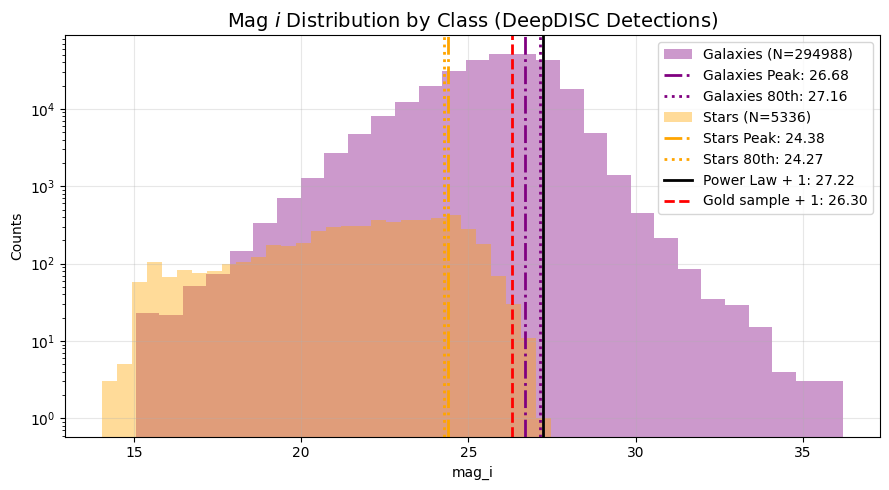

In [39]:
plt.figure(figsize=(9, 5))
for cls, label, color in zip([0, 1], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (dd_det_cat['class'] == cls) & np.isfinite(dd_det_cat['mag_i'])
    mags = dd_det_cat.loc[class_mask, 'mag_i'].values
    counts, bin_edges = np.histogram(mags, bins=50)
    peak_bin_index = np.argmax(counts)
    peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
    plt.hist(mags, bins=30, alpha=0.4, color=color, label=f"{label} (N={len(mags)})")
    plt.axvline(peak_mag, color=color, linestyle='-.', linewidth=2, label=f'{label} Peak: {peak_mag:.2f}')
    plt.axvline(np.percentile(mags, 80), color=color, linestyle=':', linewidth=2, label=f'{label} 80th: {np.percentile(mags, 80):.2f}')

plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title("Mag $i$ Distribution by Class (DeepDISC Detections)", fontsize=14)
plt.tight_layout()

# Visualizing DeepDISC Predictions

Let's take a look at some of DeepDISC's detections. 

In [40]:
def stretch_color(data, clipPercent):
    return np.percentile(data, (0 + clipPercent, 100 - clipPercent))
# 4x2 grid:
# Full cutout in LogNorm and Lupton RGB
# Full Cutout with GT boxes and mask and no mask in Lupton RGB
# Zoomed in on DeepDISC detection with mask and without mask
# Zoomed in on Ground Truth objects within det's bbox + 20 on all sides with mask and without mask 
def plot_det(dd_row, gt_row, astrotest_metadata):
    img = np.load(gt_row['file_name'])
    r = img[3, :, :]  # i
    g = img[2, :, :]  # r
    b = img[1, :, :]  # g
    pmin = np.percentile([r, g, b], 1)
    pmax = np.percentile([r, g, b], 99.5)
    stretch = pmax - pmin # ~27.160368
    vis_img = make_lupton_rgb(r, g, b, minimum=pmin, stretch=stretch, Q=8)
    
    # need to create two visualizers since the Visualizer class has internal image state
    # and each drawing operation modifies that same underlying canvas
    v_gt = Visualizer(
        vis_img.copy(),
        metadata=astrotest_metadata,
        scale=1,
        enable_color_jitter=False,
        instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v_gt_nm = Visualizer(
        vis_img.copy(),
        metadata=astrotest_metadata,
        scale=1,
        enable_color_jitter=False,
        instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    groundTruth = v_gt.draw_dataset_dict(gt_row, lf=False, alpha=0.5, boxf=True)
    groundTruth_nm = v_gt_nm.draw_dataset_dict(gt_row, lf=False, alpha=0.5, boxf=True, draw_masks=False)
    # 1st row
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    # plt.imshow(img[:, :, 3], norm=colors.LogNorm(), cmap='viridis') # show i band
    # plt.imshow(r, norm=asinh_norm(r), cmap='viridis') # show i band
    plt.imshow(r, clim=stretch_color(r, 1))
    plt.subplot(1, 2, 2)
    plt.imshow(vis_img)
    # 2nd row
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(groundTruth_nm.get_image())
    plt.subplot(1, 2, 2)
    plt.imshow(groundTruth.get_image())
    
    # 3rd row
    dd_label_map = {0: "Galaxy", 1: "Star"}
    wcs = WCS(gt_row['wcs'])
    dd_skycoords = SkyCoord(ra=dd_row['ra'] * u.deg, dec=dd_row['dec'] * u.deg)
    dd_x_pix, dd_y_pix = wcs.world_to_pixel(dd_skycoords)
    dd_row['cutout_x'] = dd_x_pix
    dd_row['cutout_y'] = dd_y_pix
    
    # we need to turn our detection into a Detectron2 Instance
    height = gt_row['height']
    width = gt_row['width']
    dd_instance = Instances((height, width))
    dd_instance.pred_boxes = Boxes(torch.tensor([dd_row['bbox']]))
    dd_instance.scores = torch.tensor([dd_row['score']])
    dd_instance.pred_classes = torch.tensor([dd_row['class']])
    # and rebuild mask from RLE
    rle_dict = dd_row['rle_masks'].copy()
    rle_dict['counts'] = rle_dict['counts'].encode('utf-8')
    mask = mask_util.decode(rle_dict).astype(bool)
    dd_instance.pred_masks = torch.from_numpy(mask).unsqueeze(0).to(torch.bool)
    
    dd_viz_scale = 1
    xmin, ymin, xmax, ymax = dd_row['bbox']
    xmin = xmin - 20 if xmin - 20 >= 0 else 0
    ymin = ymin - 20 if ymin - 20 >= 0 else 0
    xmax = xmax + 20 if xmax + 20 <= width else width
    ymax = ymax + 20 if ymax + 20 <= height else height
    v_dd = Visualizer(
        vis_img.copy(),
        metadata=astrotest_metadata,
        scale=dd_viz_scale,
        enable_color_jitter=False,
        instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v_dd_nm = Visualizer(
        vis_img.copy(),
        metadata=astrotest_metadata,
        scale=dd_viz_scale,
        enable_color_jitter=False,
        instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    
    dd = v_dd.draw_instance_predictions(dd_instance, lf=False, alpha=0.5, boxf=True)
    dd_nm = v_dd_nm.draw_instance_predictions(dd_instance, lf=False, alpha=0.5, boxf=True, draw_masks=False)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(dd_nm.get_image())
    plt.scatter(dd_row['cutout_x'] * dd_viz_scale, dd_row['cutout_y'] * dd_viz_scale, marker='x', s=200, c=['red'])
    plt.xlim(xmin * dd_viz_scale, xmax * dd_viz_scale)
    plt.ylim(ymax * dd_viz_scale, ymin * dd_viz_scale)
    plt.gca().set_aspect('equal')
    plt.title(f'DeepDISC Detection (no mask) - {dd_label_map.get(dd_row["class"], "?")} ({dd_row["score"]:.3f})', fontsize=12)
    # plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(dd.get_image())
    plt.scatter(dd_row['cutout_x'] * dd_viz_scale, dd_row['cutout_y'] * dd_viz_scale, marker='x', s=200, c=['red'])
    plt.xlim(xmin * dd_viz_scale, xmax * dd_viz_scale)
    plt.ylim(ymax * dd_viz_scale, ymin * dd_viz_scale)
    plt.gca().set_aspect('equal')
    plt.title(f'DeepDISC Detection (with mask) - {dd_label_map.get(dd_row["class"], "?")} ({dd_row["score"]:.3f})', fontsize=12)
    # plt.axis('off')
    
    # 4th row
    # print(xmin, ymin, xmax, ymax)
    # annotations from gt_row that fall within xmax, xmin, ymax, ymin
    objs_in_bbox = []
    for obj in gt_row['annotations']:
        obj_xmin, obj_ymin, w, h = obj['bbox']
        obj_xmax = obj_xmin + w
        obj_ymax = obj_ymin + h
        # print(f"GT obj bbox: {obj['obj_id']} - xmin: {obj_xmin}, ymin: {obj_ymin}, xmax: {obj_xmax}, ymax: {obj_ymax}")
        if obj_xmin >= xmin and obj_xmax <= xmax and obj_ymin >= ymin and obj_ymax <= ymax:
            objs_in_bbox.append(obj)
            print(f" {obj['obj_id']} is within padded DeepDISC bbox.")
    print(f"Found {len(objs_in_bbox)} ground truth objects in DeepDISC detection bbox.")
    # turn objs_in_bbox into a df for easier handling
    objs_df = pd.DataFrame(objs_in_bbox)
    # print(objs_df)
    gt_skycoords = SkyCoord(ra=objs_df['ra'].values * u.deg, dec=objs_df['dec'].values * u.deg)
    gt_x_pix, gt_y_pix = wcs.world_to_pixel(gt_skycoords)
    objs_df['cutout_x'] = gt_x_pix
    objs_df['cutout_y'] = gt_y_pix
    # print(objs_df)
    # get all objs in bbox
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(groundTruth_nm.get_image())
    plt.scatter(objs_df['cutout_x'], objs_df['cutout_y'], marker='+', s=200, c=['yellow'])
    plt.xlim(xmin, xmax)
    plt.ylim(ymax, ymin)
    plt.subplot(1, 2, 2)
    plt.imshow(groundTruth.get_image())
    plt.scatter(objs_df['cutout_x'], objs_df['cutout_y'], marker='+', s=200, c=['yellow'])
    plt.xlim(xmin, xmax)
    plt.ylim(ymax, ymin)

## Random Detection

In [237]:
np.random.seed(43) # 41 is good
rand_det_id = np.random.choice(dd_det_cat['id'].values)
dd_det = dd_det_cat[dd_det_cat['id'] == rand_det_id].iloc[0]
gt_row = test_data[test_data['file_name'] == dd_det['file_name']]
assert len(gt_row) == 1, "Multiple or no matches found in test data for the given detection."
gt_row = gt_row.iloc[0]
gt_row

file_name         /u/yse2/lsst_data/truth/52.61_-42.0/c192_52.61...
image_id                                                        192
height                                                          143
width                                                           150
tile                                                    52.61_-42.0
det_cat_path      /u/yse2/lsst_data/truth/52.61_-42.0/det_c192_5...
truth_cat_path    /u/yse2/lsst_data/truth/52.61_-42.0/truth_c192...
wcs               WCSAXES =                    2                ...
annotations       [{'obj_id': 10252211413, 'obj_truth_idx': 4, '...
Name: 510, dtype: object

Setting colors
Setting colors
 10252198961 is within padded DeepDISC bbox.
 10251717375 is within padded DeepDISC bbox.
 10250196392 is within padded DeepDISC bbox.
 10253363807 is within padded DeepDISC bbox.
Found 4 ground truth objects in DeepDISC detection bbox.


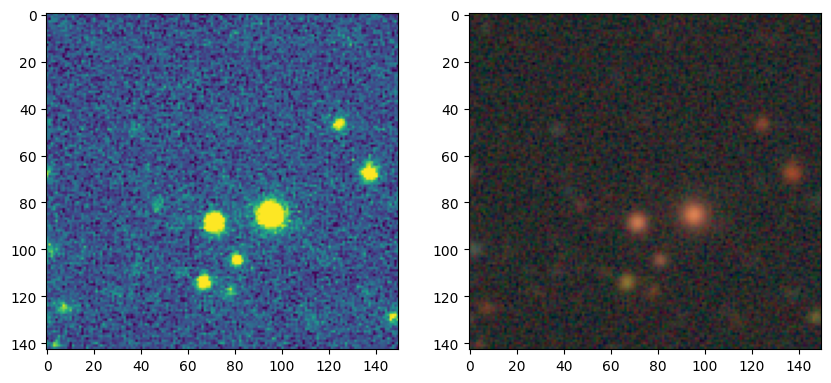

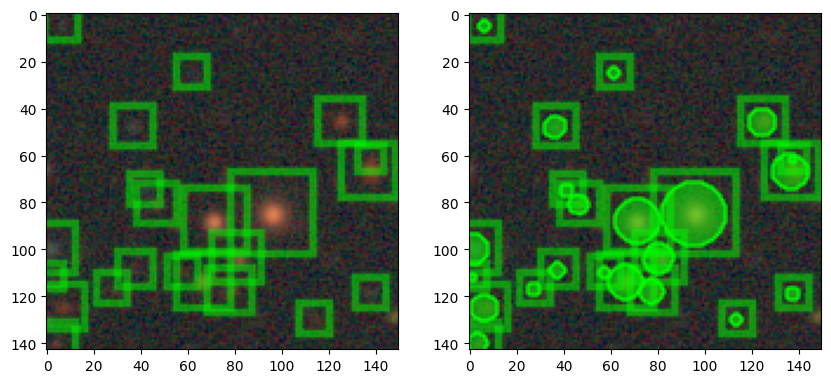

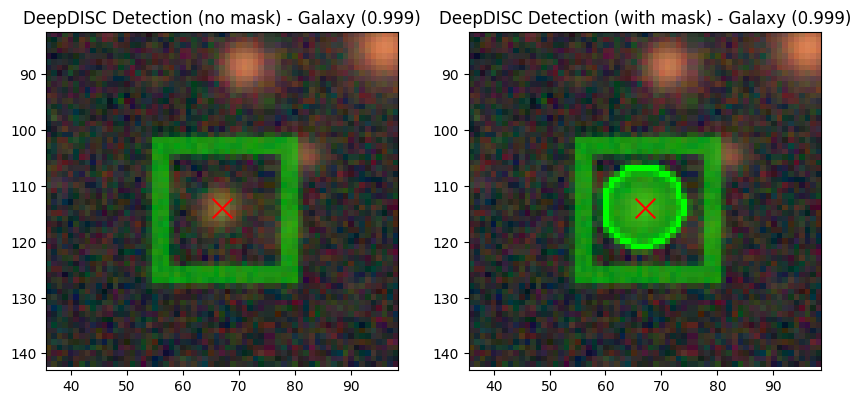

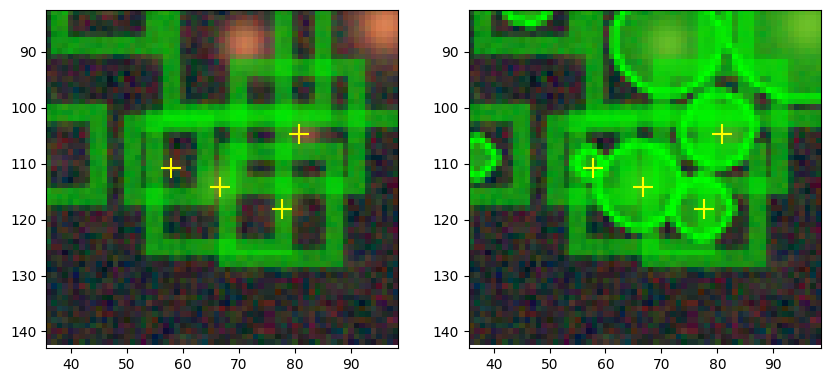

In [239]:
plot_det(dd_det, gt_row, astrotest_metadata)

## Faint Galaxy Detection

In [257]:
det_id = dd_det_cat[dd_det_cat['class'] == 0].loc[dd_det_cat[dd_det_cat['class'] == 0]['mag_i'].idxmax(), 'id']
print("Faintest galaxy detection ID:", det_id)
dd_det = dd_det_cat[dd_det_cat['id'] == det_id].iloc[0]
print(dd_det)
gt_row = test_data[test_data['file_name'] == dd_det['file_name']]
assert len(gt_row) == 1, "Multiple or no matches found in test data for the given detection."
gt_row = gt_row.iloc[0]
gt_row

Faintest galaxy detection ID: 185993
id                                                      185993
ra                                                    51.81638
dec                                                 -38.170567
class                                                        0
file_name    /u/yse2/lsst_data/truth/51.76_-38.1/c152_51.76...
bbox         [73.1921615601, 51.2527236938, 86.193901062, 6...
score                                                 0.574411
rle_masks       {'size': [148, 148], 'counts': 'mU;4`400Ohh9'}
mag_u                                                 27.84631
mag_g                                                27.949131
mag_r                                                27.989981
mag_i                                                34.677826
mag_z                                                      NaN
mag_y                                                26.559732
Name: 185993, dtype: object


file_name         /u/yse2/lsst_data/truth/51.76_-38.1/c152_51.76...
image_id                                                        152
height                                                          148
width                                                           148
tile                                                    51.76_-38.1
det_cat_path      /u/yse2/lsst_data/truth/51.76_-38.1/det_c152_5...
truth_cat_path    /u/yse2/lsst_data/truth/51.76_-38.1/truth_c152...
wcs               WCSAXES =                    2                ...
annotations       [{'obj_id': 8627764565, 'obj_truth_idx': 3, 'c...
Name: 6710, dtype: object

Setting colors
Setting colors
 8627200094 is within padded DeepDISC bbox.
 8627563396 is within padded DeepDISC bbox.
 8632352682 is within padded DeepDISC bbox.
 8639229812 is within padded DeepDISC bbox.
Found 4 ground truth objects in DeepDISC detection bbox.


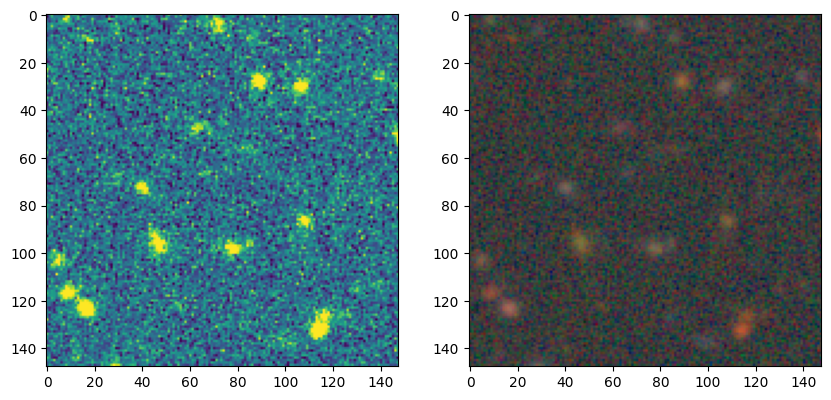

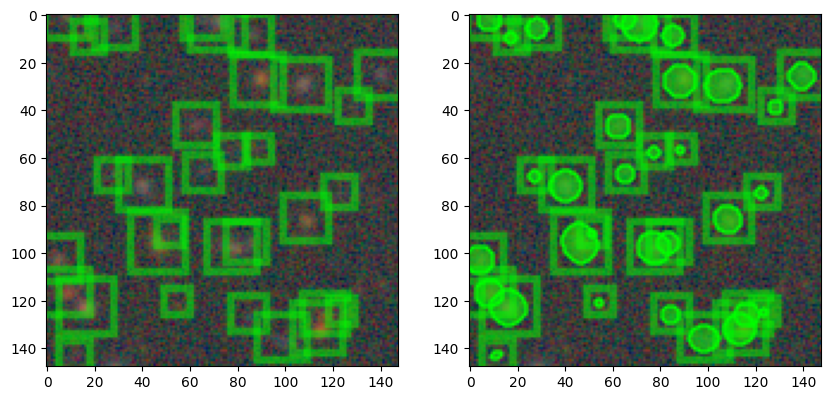

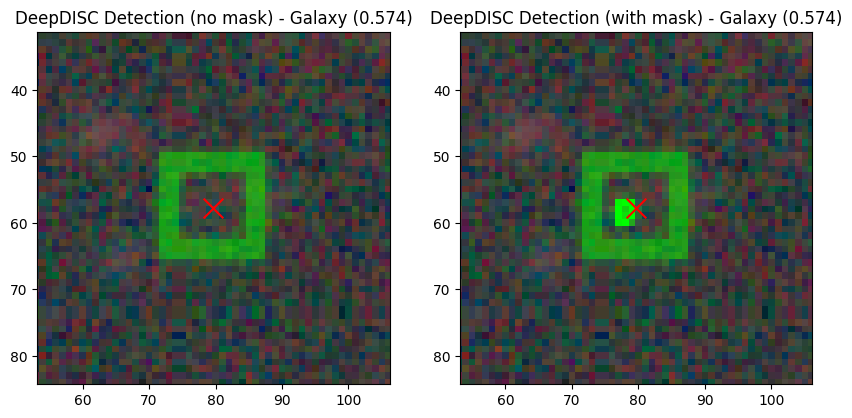

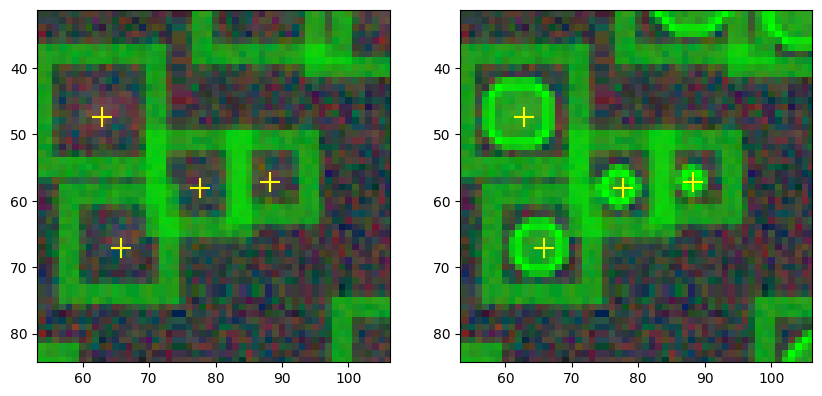

In [258]:
plot_det(dd_det, gt_row, astrotest_metadata)

## Bright Galaxy Detection

In [ ]:
det_id = dd_det_cat[dd_det_cat['class'] == 0].loc[dd_det_cat[dd_det_cat['class'] == 0]['mag_i'].idxmin(), 'id']
print("Brightest galaxy detection ID:", det_id)
dd_det = dd_det_cat[dd_det_cat['id'] == det_id].iloc[0]
print(dd_det)
gt_row = test_data[test_data['file_name'] == dd_det['file_name']]
assert len(gt_row) == 1, "Multiple or no matches found in test data for the given detection."
gt_row = gt_row.iloc[0]
gt_row

Brightest galaxy detection ID: 172347
id                                                      172347
ra                                                   52.356996
dec                                                 -39.095633
class                                                        0
file_name    /u/yse2/lsst_data/truth/52.40_-39.0/c71_52.40_...
bbox         [7.1359901428, 0.0053443909, 125.9138336182, 1...
score                                                 0.983562
rle_masks    {'size': [147, 148], 'counts': 'hU1S1^35L5C;H8...
mag_u                                                18.063253
mag_g                                                16.336285
mag_r                                                15.465882
mag_i                                                15.058482
mag_z                                                14.779809
mag_y                                                14.571769
Name: 172347, dtype: object


file_name         /u/yse2/lsst_data/truth/52.40_-39.0/c71_52.40_...
image_id                                                         71
height                                                          147
width                                                           148
tile                                                    52.40_-39.0
det_cat_path      /u/yse2/lsst_data/truth/52.40_-39.0/det_c71_52...
truth_cat_path    /u/yse2/lsst_data/truth/52.40_-39.0/truth_c71_...
wcs               WCSAXES =                    2                ...
annotations       [{'obj_id': 8627733687, 'obj_truth_idx': 5, 'c...
Name: 6214, dtype: object

Setting colors
Setting colors
 8628671463 is within padded DeepDISC bbox.
 8628082944 is within padded DeepDISC bbox.
Found 2 ground truth objects in DeepDISC detection bbox.


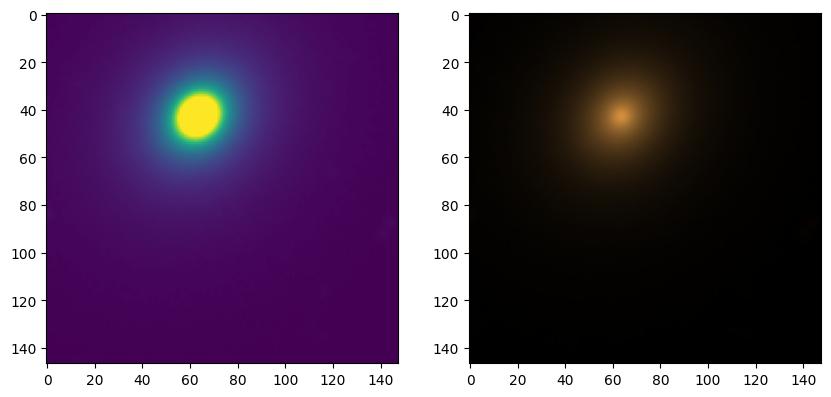

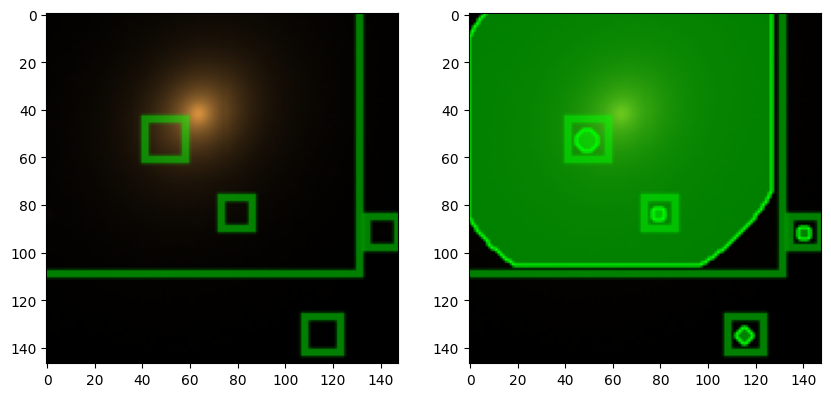

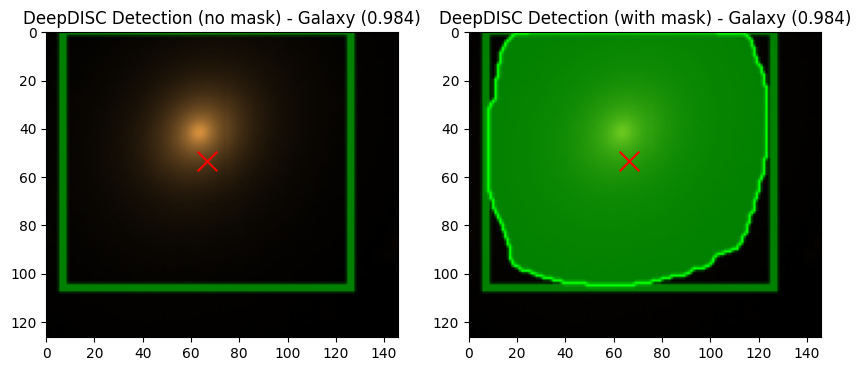

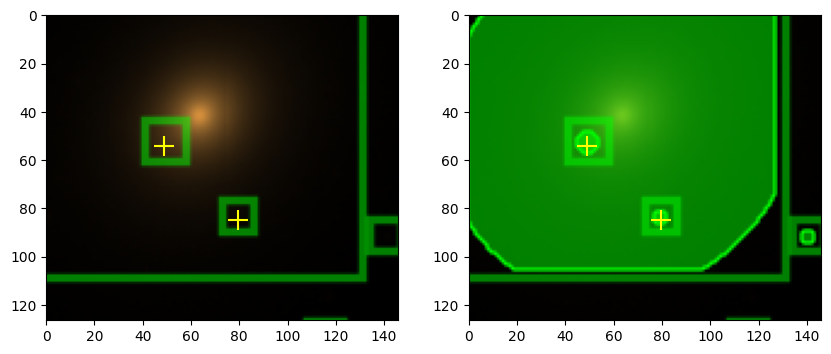

In [260]:
plot_det(dd_det, gt_row, astrotest_metadata)

## Faint Star Detection

In [261]:
det_id = dd_det_cat[dd_det_cat['class'] == 1].loc[dd_det_cat[dd_det_cat['class'] == 1]['mag_i'].idxmax(), 'id']
print("Faintest star detection ID:", det_id)
dd_det = dd_det_cat[dd_det_cat['id'] == det_id].iloc[0]
print(dd_det)
gt_row = test_data[test_data['file_name'] == dd_det['file_name']]
assert len(gt_row) == 1, "Multiple or no matches found in test data for the given detection."
gt_row = gt_row.iloc[0]
gt_row

Faintest star detection ID: 146380
id                                                      146380
ra                                                   51.011329
dec                                                  -41.33739
class                                                        1
file_name    /u/yse2/lsst_data/truth/51.01_-41.3/c81_51.01_...
bbox         [139.2808685303, 42.738899231, 147.9969329834,...
score                                                 0.522726
rle_masks     {'size': [148, 148], 'counts': '_kd04_411O1NaN'}
mag_u                                                      NaN
mag_g                                                      NaN
mag_r                                                28.183317
mag_i                                                26.699255
mag_z                                                25.939993
mag_y                                                25.190573
Name: 146380, dtype: object


file_name         /u/yse2/lsst_data/truth/51.01_-41.3/c81_51.01_...
image_id                                                         81
height                                                          148
width                                                           148
tile                                                    51.01_-41.3
det_cat_path      /u/yse2/lsst_data/truth/51.01_-41.3/det_c81_51...
truth_cat_path    /u/yse2/lsst_data/truth/51.01_-41.3/truth_c81_...
wcs               WCSAXES =                    2                ...
annotations       [{'obj_id': 40745437772, 'obj_truth_idx': 0, '...
Name: 5275, dtype: object

Setting colors
Setting colors
 9440014915 is within padded DeepDISC bbox.
Found 1 ground truth objects in DeepDISC detection bbox.


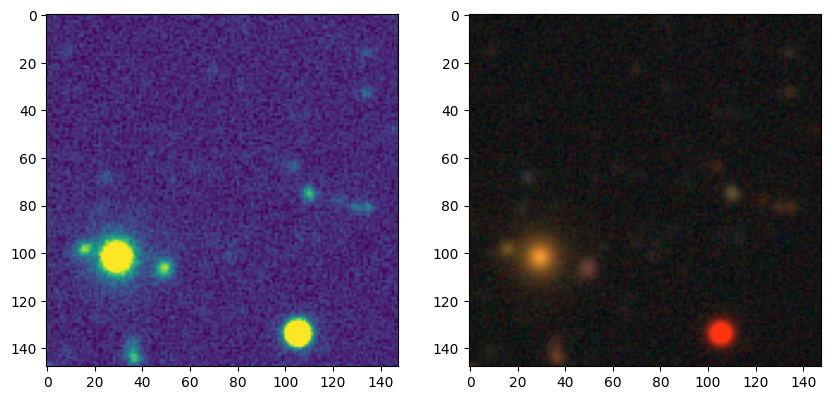

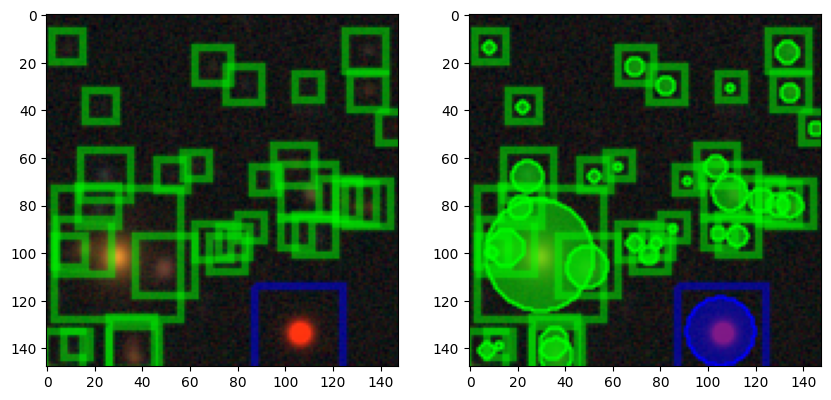

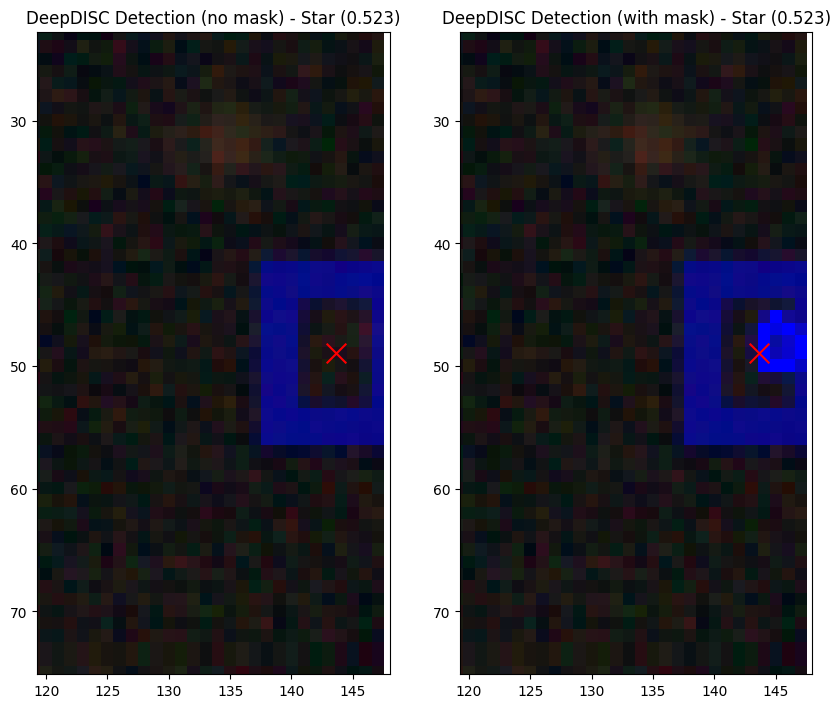

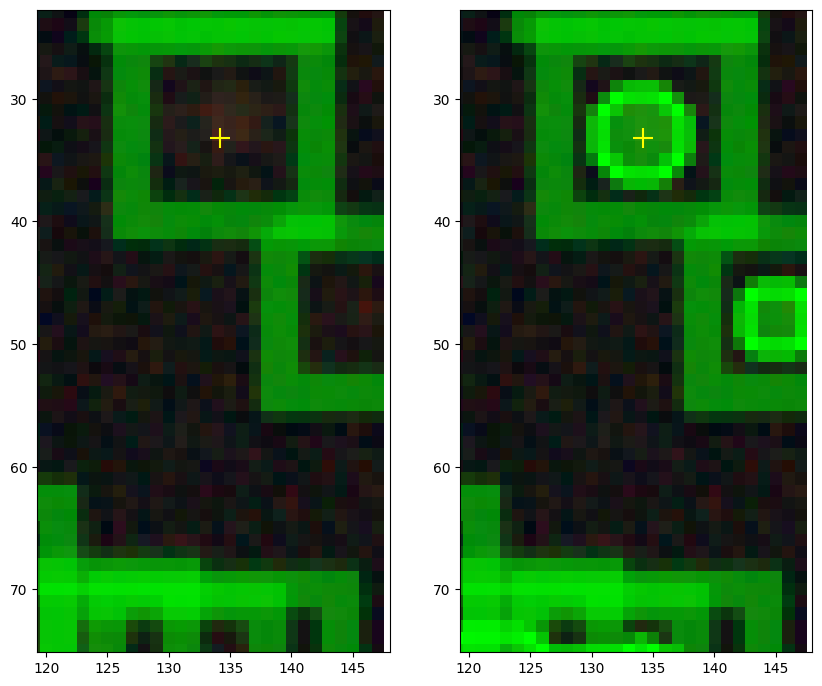

In [262]:
plot_det(dd_det, gt_row, astrotest_metadata)

## Bright Star Detection

In [263]:
det_id = dd_det_cat[dd_det_cat['class'] == 1].loc[dd_det_cat[dd_det_cat['class'] == 1]['mag_i'].idxmin(), 'id']
print("Brightest star detection ID:", det_id)
dd_det = dd_det_cat[dd_det_cat['id'] == det_id].iloc[0]
print(dd_det)
gt_row = test_data[test_data['file_name'] == dd_det['file_name']]
assert len(gt_row) == 1, "Multiple or no matches found in test data for the given detection."
gt_row = gt_row.iloc[0]
gt_row

Brightest star detection ID: 210679
id                                                      210679
ra                                                   54.117736
dec                                                 -39.152814
class                                                        1
file_name    /u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...
bbox         [0.0, 9.277305603, 97.2664642334, 142.3883056641]
score                                                 0.996709
rle_masks    {'size': [148, 149], 'counts': '<P4b04N00000O1...
mag_u                                                14.425501
mag_g                                                14.339454
mag_r                                                14.194592
mag_i                                                14.041258
mag_z                                                14.011086
mag_y                                                13.699539
Name: 210679, dtype: object


file_name         /u/yse2/lsst_data/truth/54.11_-39.1/c186_54.11...
image_id                                                        186
height                                                          148
width                                                           149
tile                                                    54.11_-39.1
det_cat_path      /u/yse2/lsst_data/truth/54.11_-39.1/det_c186_5...
truth_cat_path    /u/yse2/lsst_data/truth/54.11_-39.1/truth_c186...
wcs               WCSAXES =                    2                ...
annotations       [{'obj_id': 31412546900, 'obj_truth_idx': 0, '...
Name: 7589, dtype: object

Setting colors
Setting colors
 31412546900 is within padded DeepDISC bbox.
 8687798636 is within padded DeepDISC bbox.
Found 2 ground truth objects in DeepDISC detection bbox.


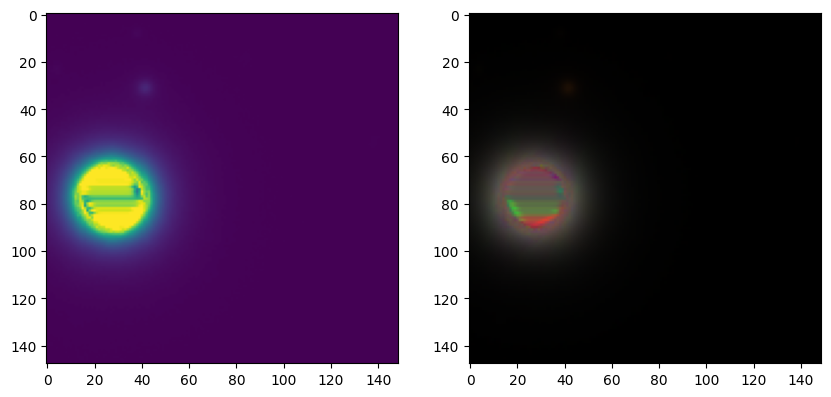

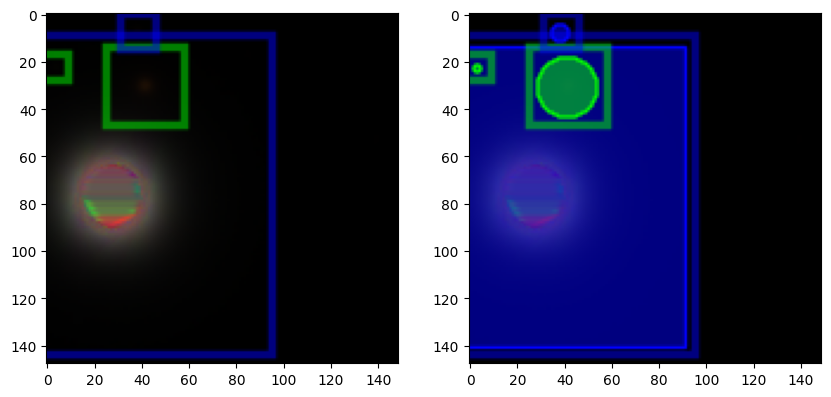

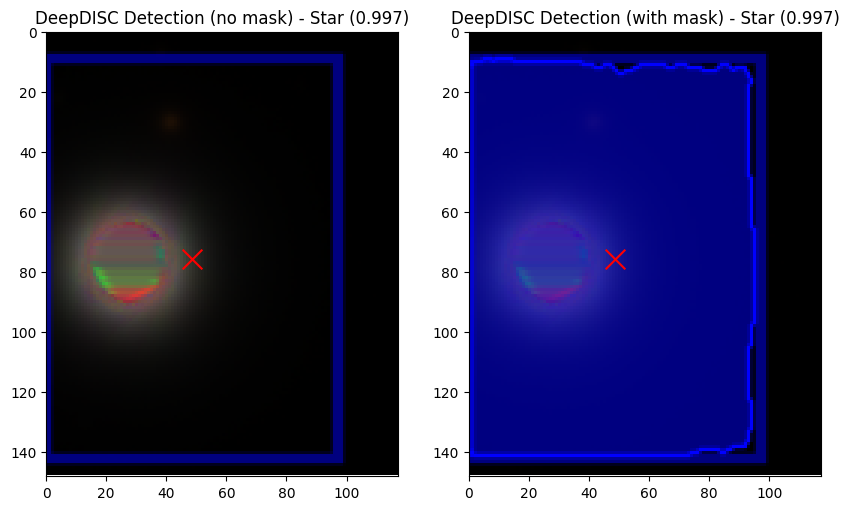

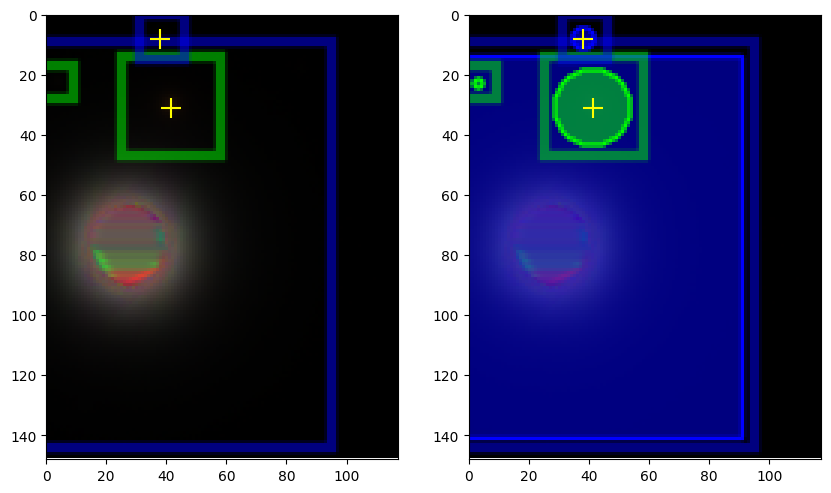

In [264]:
plot_det(dd_det, gt_row, astrotest_metadata)